# Imports

In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import seaborn as sb
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf

# PCA

In [9]:
def normalize(X):
    mu  = np.mean(X, axis=0)
    std = np.std(X, axis=0)

    std_filled = std.copy()
    std_filled[std==0] = 1.

    X_norm = ((X-mu)/std_filled)

    return X_norm, mu, std

# calculating the covariance matrix of the mean-centered data.
def calc_covMat(X_norm):
    cov_mat = np.cov(X_norm , rowvar = False)

    return cov_mat

#Calculating Eigenvalues and Eigenvectors of the covariance matrix
def calc_eigen(cov_mat):
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)

    return eigen_values , eigen_vectors

#sort the eigenvalues in descending order
def sort_eigen(eigen_values , eigen_vectors):
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]

    #similarly sort the eigenvectors
    sorted_eigenvectors = eigen_vectors[:,sorted_index]

    return sorted_eigenvectors

# select the first n eigenvectors, n is desired dimension
# of our final reduced data.
def select_eigensubset(sorted_eigenvectors, n_components = 2):
    eigenvector_subset = sorted_eigenvectors[:,0:n_components]

    return eigenvector_subset

#Transform the data
def reduce_dimension(X_norm, eigenvector_subset):
    X_reduced = np.dot(eigenvector_subset.transpose(),X_norm.transpose()).transpose()

    return X_reduced

def PCA(X , num_components):
    #Step-1
    X_norm, _, _ = normalize(X)

    #Step-2
    cov_mat = calc_covMat(X_norm)

    #Step-3
    eigen_values , eigen_vectors = calc_eigen(cov_mat)

    #Step-4
    sorted_eigenvectors = sort_eigen(eigen_values , eigen_vectors)

    #Step-5
    eigenvector_subset = select_eigensubset(sorted_eigenvectors, n_components = num_components)

    #Step-6
    X_reduced = reduce_dimension(X_norm, eigenvector_subset)

    return X_reduced

# K-means clustering

In [8]:
def norm(x):
  sum = 0
  for elm in x:
    sum = sum + elm*elm
  return np.sqrt(sum)

def cosDist(a, b):
  return 1 - ((a @ b) / (norm(a)*norm(b)))

def distanceCalc(data, centroids, idx):
  distances = [0 for x in range(len(centroids))]
  counts = [0 for x in range(len(centroids))]
  i = 0
  for elm in data:
    temp2 = elm-centroids[int(idx[i][0]),:]
    #dist = temp2 @ temp2.T
    dist = cosDist(elm, centroids[int(idx[i][0]),:])
    distances[int(idx[i][0])] = distances[int(idx[i][0])] + dist
    counts[int(idx[i][0])] = counts[int(idx[i][0])] + 1
    i = i + 1

  new_dists = []
  for i in range(len(centroids)):
    if counts[i] != 0:
      distances[i] = distances[i]/counts[i]
      if not np.isnan(distances[i]):
        new_dists.append(distances[i])

  new_dists = np.array(new_dists)
  #print(distances)
  return np.average(new_dists)

def findClosestCentroids(X,centroids):
    K = centroids.shape[0]
    idx = np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
        distance = np.inf
        temp1 = 0
        for k in range(K):
            temp2 = X[i,:]-centroids[k,:]
            dis_t = temp2 @ temp2.T
            dis_t = cosDist(X[i,:], centroids[k,:])
            if (dis_t<distance):
                distance = dis_t
                temp1 = k
        idx[i] = temp1

    return idx

def computeCentroids(X,idx,K):
    m,n = X.shape
    centroids = np.zeros((K,n))
    cent = []
    for k in range(K):
        cent = np.zeros((1,n))
        Ck = 0
        for i in range(m):
            if idx[i] == k:
                cent = cent + X[i,:]
                Ck = Ck + 1
        if Ck != 0:
          centroids[k,:] = cent * (1 / Ck)

    return centroids

def plotkMeans(X,idx,num_CL,C_H,it):
    colors = ('b','g','r','c','m','y','k')
    plt.figure
    for i in range(num_CL):
        CL_i = X[np.where(idx == i)[0],:]
        plt.plot(CL_i[:,0],CL_i[:,1], colors[i]+'o',)
        plt.plot(C_H[i,0,0:it+2],C_H[i,1,0:it+2],'kx-')

    plt.show()
    return 0

def runkMeans(X, init_cents, max_iters, plotProgress= False):
    m, n = X.shape
    k = init_cents.shape[0]
    idx = np.zeros((m))
    centroids = init_cents
    cent_hist = np.zeros((init_cents.shape[0],init_cents.shape[1],max_iters+1))
    cent_hist[:,:,0] = init_cents

    # K-Means:
    for i in range(max_iters):
        if plotProgress:
          print('Running the {} iteration of {}'.format(i+1,max_iters))
        idx = findClosestCentroids(X, centroids)
        centroids = computeCentroids(X, idx, k)
        cent_hist[:,:,i+1] = centroids

        if plotProgress:
            plotkMeans(X, idx, init_cents.shape[0], cent_hist,i)

    return centroids, idx

def kMeansInitCentroids(X,K):
    cents = np.zeros((K, X.shape[1]))
    randindx = np.random.permutation(X.shape[0])
    cents = X[randindx[0:K],:]

    return cents

In [7]:
def purityCalc(df, best_idx):
  purity = 0
  cluster_df = pd.DataFrame()
  cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
  cluster_count = (max(cluster_df['clusters'].unique())+1)
  for i in range(max(cluster_df['clusters'].unique())+1):
    inds = cluster_df[cluster_df['clusters'] == i].index
    values = df['topic'][inds].value_counts()
    if len(values) > 0:
      cluster_purity = max(values)/len(inds)
    else:
      cluster_purity = 0
    #print('Cluster:', i, ", Purity:", cluster_purity)
    purity = purity + cluster_purity
  purity = purity/cluster_count
  #print('Purity:', purity)
  return purity

# Keywords

In [2]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def build_vocabulary(self, captions):
            for caption in captions:
                words = nltk.word_tokenize(caption.lower())
                for word in words:
                    self.add_word(WordNetLemmatizer().lemmatize(word))

In [3]:
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
word2idx = {}
idx2word = {}
idx = 0
with open("keywords.txt") as file:
    for line in file:
        line = line.rstrip()
        word = line.split(' ')[0]
        word2idx[word] = idx
        idx2word[idx] = word
        idx = idx + 1

# 1. Original dataset

In [5]:
data_path = "dataset_6.csv"
df = pd.read_csv(data_path)
df

,question,answer,difficulty,topic
0,What is supervised machine learning?,Supervised learning is a type of machine learn...,beginner,supervised learning
1,What is regression? Which models can you use t...,Regression is a part of supervised ML. Regress...,beginner,supervised learning
2,What is linear regression? When do we use it?,Linear regression is a model that assumes a li...,beginner,supervised learning
3,What are the main assumptions of linear regres...,There are several assumptions of linear regres...,intermediate,supervised learning
4,What’s the normal distribution? Why do we care...,The normal distribution is a continuous probab...,beginner,supervised learning
...,...,...,...,...
162,Which models do you know for solving time seri...,* Simple Exponential Smoothing: approximate th...,intermediate,time series
163,"If there’s a trend in our series, how we can r...",We can explicitly model the trend (and/or seas...,intermediate,time series
164,You have a series with only one variable “y” m...,We want to look at the correlation between dif...,intermediate,time series
165,You have a series with a variable “y” and a se...,Given the assumption that the set of features ...,intermediate,time series


In [ ]:
df['topic'].value_counts()

,count
topic,
neural networks,34
feature selection,30
classification,21
unsupervised learning,21
supervised learning,20
text classification,14
regularization,13
recommender systems,7
time series,7


## 1. Tokenizer

In [6]:
key_vectors = []
vec_len = 10
#vec_len = 5
for text in list(df['question']):
  vec_rep = []
  words = nltk.word_tokenize(text.lower())
  keywords = []
  for word in words:
      new_word = WordNetLemmatizer().lemmatize(word)
      if new_word in word2idx and new_word not in keywords:
        keywords.append(new_word)
        vec_rep.append(word2idx[new_word])
  #vec_rep.sort()
  if len(vec_rep) >= vec_len:
    vec_rep = vec_rep[:vec_len]
  else:
    vec_rep = vec_rep + [0 for x in range(vec_len - len(vec_rep))]
  vec_rep = np.array(vec_rep)
  key_vectors.append(vec_rep)
key_vectors = np.array(key_vectors)
key_vectors

array([[102,  37,  10, ...,   0,   0,   0],
       [  6,   1,  38, ...,   0,   0,   0],
       [  4,   6,   0, ...,   0,   0,   0],
       ...,
       [ 22,  17,  29, ...,   0,   0,   0],
       [ 22,  17,  62, ...,   0,   0,   0],
       [  3,   2,  31, ...,   0,   0,   0]])

### Reduced

In [ ]:
mat_reduced = PCA(key_vectors, 3)
mat_reduced

array([[ 6.28597575e-01, -3.21210704e-01, -3.23319596e-01],
       [ 7.53839913e-01,  3.83438578e-01,  6.73912605e-01],
       [ 1.12691593e+00,  5.60292365e-01,  8.27593423e-01],
       [ 4.44697425e-01, -1.75239939e-01, -1.81209554e-01],
       [ 6.59823448e-01, -1.16527329e-01, -1.11188553e-01],
       [ 1.61949589e-01, -1.34397066e-01, -1.28501243e-02],
       [-4.80399916e+00,  5.57444872e-01,  1.59404466e+00],
       [ 6.45988742e-01, -3.04879288e-01, -2.71449030e-01],
       [ 9.45867868e-01,  3.69703153e-01,  5.47981742e-01],
       [ 4.54091705e-01, -3.28256526e-01, -4.23232288e-01],
       [-8.11376854e-02,  8.64419858e-02,  2.93220260e-01],
       [ 4.02782452e-01, -3.03579232e-01, -3.78988838e-01],
       [ 2.89900305e-01, -7.61557414e-01, -9.82699911e-01],
       [ 4.96273479e-01, -5.57694635e-01, -6.79697163e-01],
       [ 8.94522698e-01, -1.52099002e-01, -8.06593792e-02],
       [ 8.86722424e-01, -1.64389942e-01, -9.74973885e-02],
       [-2.64260374e+00,  6.58010708e-01

In [ ]:
#Creating a Pandas DataFrame of reduced Dataset
principal_df = pd.DataFrame(mat_reduced, columns = ['PC1','PC2','PC3'])
principal_df

,PC1,PC2,PC3
0,0.628598,-0.321211,-0.323320
1,0.753840,0.383439,0.673913
2,1.126916,0.560292,0.827593
3,0.444697,-0.175240,-0.181210
4,0.659823,-0.116527,-0.111189
...,...,...,...
162,0.466862,0.316296,0.637596
163,1.116447,0.472779,0.721590
164,-2.235319,1.064197,1.817826
165,-3.988144,1.330022,1.698421


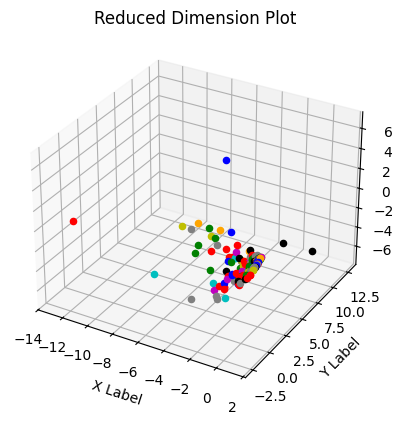

In [ ]:
targets = [elm for elm in df.loc[:, 'topic']]
ratings = pd.Categorical(targets)
principal_df['topic'] = ratings.codes

colors = ('b','g','r','c','m','y','k','orange','gray','yellow')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(principal_df["PC1"])):
  ax.scatter(principal_df["PC1"][i], principal_df["PC2"][i], principal_df["PC3"][i], marker='o', color=colors[principal_df["topic"][i]])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title('Reduced Dimension Plot')
plt.show()

## 2. Bag of words

In [10]:
bag_vectors = []
for text in list(df['question']):
  bag_vec = [0 for x in word2idx]
  words = nltk.word_tokenize(text.lower())
  for word in words:
      new_word = WordNetLemmatizer().lemmatize(word)
      if new_word in word2idx:
        bag_vec[word2idx[new_word]] = bag_vec[word2idx[new_word]] + 1
  bag_vec = np.array(bag_vec)
  bag_vectors.append(bag_vec)
bag_vectors = np.array(bag_vectors)
print(bag_vectors.shape)
bag_vectors

(167, 198)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

### Visualization

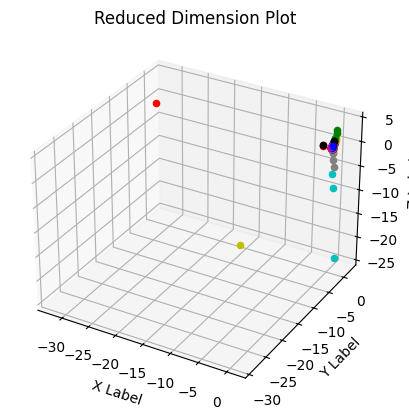

In [ ]:
data = bag_vectors
mat_reduced = PCA(data, 3)
principal_df = pd.DataFrame(mat_reduced, columns = ['PC1','PC2','PC3'])
targets = [elm for elm in df.loc[:, 'topic']]
ratings = pd.Categorical(targets)
principal_df['topic'] = ratings.codes

colors = ('b','g','r','c','m','y','k','orange','gray','yellow')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(principal_df["PC1"])):
  ax.scatter(principal_df["PC1"][i], principal_df["PC2"][i], principal_df["PC3"][i], marker='o', color=colors[principal_df["topic"][i]])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title('Reduced Dimension Plot')
plt.show()

### Clustering first and then reduction

#### Clustering

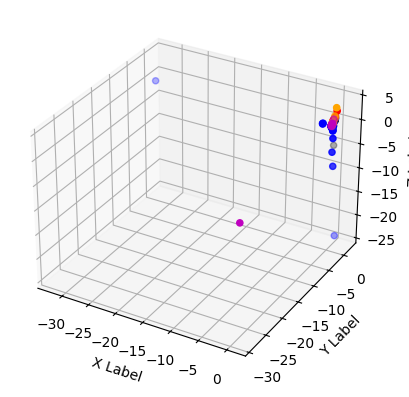

In [ ]:
data = bag_vectors
#mat_reduced = PCA(data, 3)
K = 9
#data = mat_reduced
min_dist = 1000000000
best_p = 0
best_centrs, best_idx = None, None
for i in range(20):
    max_iters = 100
    init_cents = kMeansInitCentroids(data, K)
    centroids, idx = runkMeans(data, init_cents, max_iters)
    dist = distanceCalc(data, centroids, idx)
    p = purityCalc(idx)
    #if dist < min_dist:
    #  min_dist = dist
    if best_p < p:
      best_p = p
      best_centrs, best_idx = centroids, idx

data = PCA(data, 3)
colors = ('b','g','r','c','m','y','k','orange','gray','yellow')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(best_centrs)):
  CL_i = data[np.where(best_idx == i)[0],:]
  #plt.plot(CL_i[:,0],CL_i[:,1], marker='o', color=colors[i])
  ax.scatter(CL_i[:,0], CL_i[:,1], CL_i[:,2], marker='o', color=colors[i])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

#### Evaluation

In [ ]:
# k = 9
purity = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
cluster_count = (max(cluster_df['clusters'].unique())+1)
for i in range(max(cluster_df['clusters'].unique())+1):
  inds = cluster_df[cluster_df['clusters'] == i].index
  cluster_purity = max(principal_df['topic'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Purity:", cluster_purity)
  purity = purity + cluster_purity
purity = purity/cluster_count
print('Purity:', purity)

Cluster: 0 , Purity: 0.26865671641791045
Cluster: 1 , Purity: 1.0
Cluster: 2 , Purity: 0.7142857142857143
Cluster: 3 , Purity: 1.0
Cluster: 4 , Purity: 0.28
Cluster: 5 , Purity: 0.9
Cluster: 6 , Purity: 0.7333333333333333
Cluster: 7 , Purity: 0.8
Cluster: 8 , Purity: 0.8333333333333334
Purity: 0.7255121219300323


In [ ]:
# k = 9
recall = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
class_count = (len(principal_df['topic'].unique()))
for i in range(len(principal_df['topic'].unique())):
  inds = principal_df[principal_df['topic'] == principal_df['topic'].unique()[i]].index
  cluster_recall = max(cluster_df['clusters'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Recall:", cluster_recall)
  recall = recall + cluster_recall
recall = recall/class_count
print('Recall:', recall)

Cluster: 0 , Recall: 0.35
Cluster: 1 , Recall: 0.42857142857142855
Cluster: 2 , Recall: 0.7692307692307693
Cluster: 3 , Recall: 0.5333333333333333
Cluster: 4 , Recall: 0.5294117647058824
Cluster: 5 , Recall: 0.7142857142857143
Cluster: 6 , Recall: 0.7619047619047619
Cluster: 7 , Recall: 1.0
Cluster: 8 , Recall: 0.42857142857142855
Recall: 0.6128121334003687


In [ ]:
principal_df['topic'].unique()

array(['supervised learning', 'classification', 'regularization',
       'feature selection', 'neural networks', 'text classification',
       'unsupervised learning', 'recommender systems', 'time series'],
      dtype=object)

In [ ]:
# k = 9
print("                          Cross table")
print()
print("     C/K   ", end=' ')
topics = principal_df['topic'].unique()
i = 0
topics.sort()
for j in topics:
  print(i, end='    ')
  i = i + 1
print()
print('         -------------------------------------------------')
for i in range(max(cluster_df['clusters'].unique())+1):
  print("     ", end=' ')
  print(i, end='  |  ')
  for j in topics:
    inds = cluster_df[cluster_df['clusters'] == i].index
    s = [principal_df['topic'] == j][0]
    new_inds = s[s].index.values
    new_inds = [i for i in new_inds if i in inds]
    count = len(principal_df.loc[new_inds])
    if count > 99:
      print(count, end='  ')
    elif count > 9:
      print(count, end='   ')
    else:
      print(count, end='    ')
  print('|', end='  ')
  print(len(inds), end='')
  print()
print('         -------------------------------------------------')
print("           ", end=' ')
for j in topics:
  count = len(principal_df[principal_df['topic'] == j].index)
  if count > 99:
    print(count, end='  ')
  elif count > 9:
    print(count, end='   ')
  else:
    print(count, end='    ')
print()

                          Cross table

     C/K    0    1    2    3    4    5    6    7    8    
         -------------------------------------------------
      0  |  5    1    18   7    0    7    10   3    16   |  67
      1  |  0    0    1    0    0    0    0    0    0    |  1
      2  |  0    10   2    0    0    2    0    0    0    |  14
      3  |  0    0    0    0    0    3    0    0    0    |  3
      4  |  6    1    2    0    3    7    3    2    1    |  25
      5  |  9    0    0    0    0    1    0    0    0    |  10
      6  |  0    0    11   0    0    0    1    0    3    |  15
      7  |  1    16   0    0    0    0    0    2    1    |  20
      8  |  0    2    0    0    10   0    0    0    0    |  12
         -------------------------------------------------
            21   30   34   7    13   20   14   7    21   


### Reduced clustering

#### 3 dimensions

##### Elbow method

<ipython-input-3-30495f8f0749>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))


[0.37562951 0.1729217  0.09790066 0.08135092 0.02884268 0.02249185
 0.01829003 0.01377841 0.01132621]


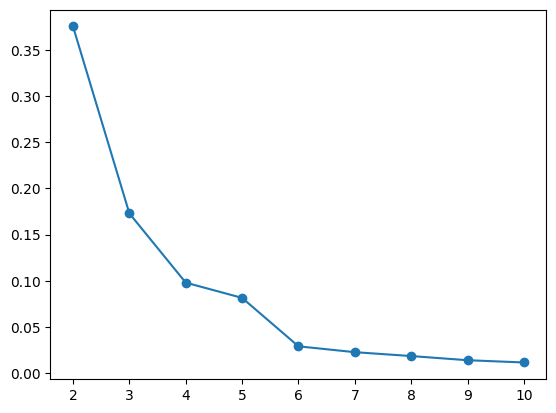

In [ ]:
data = bag_vectors
mat_reduced = PCA(data, 3)
data = mat_reduced

ks = list(range(2,11))
dists = [0 for elm in ks]

ind = 0
for K in ks:
  min_dist = 1000000000
  for i in range(20):
    max_iters = 100
    init_cents = kMeansInitCentroids(data, K)
    centroids, idx = runkMeans(data, init_cents, max_iters)
    dist = distanceCalc(data, centroids, idx)
    if dist < min_dist:
      min_dist = dist
  dists[ind] = min_dist
  ind = ind + 1

dists = np.array(dists)
print(dists)

plt.figure
plt.plot(ks, dists, 'o-')
plt.show()

##### Clusters

<ipython-input-3-30495f8f0749>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))


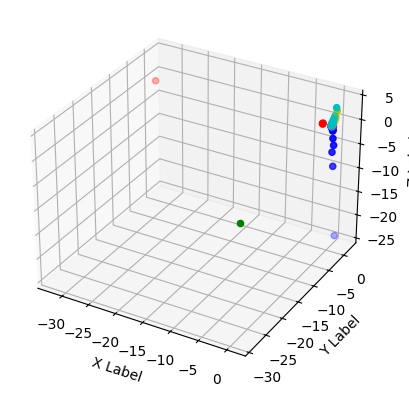

In [ ]:
data = bag_vectors
mat_reduced = PCA(data, 3)
K = 6
data = mat_reduced
min_dist = 1000000000
best_centrs, best_idx = None, None
for i in range(20):
    max_iters = 100
    init_cents = kMeansInitCentroids(data, K)
    centroids, idx = runkMeans(data, init_cents, max_iters)
    dist = distanceCalc(data, centroids, idx)
    if dist < min_dist:
      min_dist = dist
      best_centrs, best_idx = centroids, idx

colors = ('b','g','r','c','m','y','k','orange','gray','yellow')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(best_centrs)):
  CL_i = data[np.where(best_idx == i)[0],:]
  #plt.plot(CL_i[:,0],CL_i[:,1], marker='o', color=colors[i])
  ax.scatter(CL_i[:,0], CL_i[:,1], CL_i[:,2], marker='o', color=colors[i])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

##### Evaluation

In [ ]:
purity = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
cluster_count = (max(cluster_df['clusters'].unique())+1)
for i in range(max(cluster_df['clusters'].unique())+1):
  inds = cluster_df[cluster_df['clusters'] == i].index
  cluster_purity = max(df['topic'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Purity:", cluster_purity)
  purity = purity + cluster_purity
purity = purity/cluster_count
print('Purity:', purity)

Cluster: 0 , Purity: 0.6363636363636364
Cluster: 1 , Purity: 1.0
Cluster: 2 , Purity: 0.75
Cluster: 3 , Purity: 0.3157894736842105
Cluster: 4 , Purity: 0.3770491803278688
Cluster: 5 , Purity: 0.3076923076923077
Purity: 0.5644824330113373


In [ ]:
recall = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
class_count = (max(principal_df['topic'].unique())+1)
for i in range(max(principal_df['topic'].unique())+1):
  inds = principal_df[principal_df['topic'] == i].index
  cluster_recall = max(cluster_df['clusters'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Recall:", cluster_recall)
  recall = recall + cluster_recall
recall = recall/class_count
print('Recall:', recall)

Cluster: 0 , Recall: 0.6666666666666666
Cluster: 1 , Recall: 0.5333333333333333
Cluster: 2 , Recall: 0.6764705882352942
Cluster: 3 , Recall: 0.42857142857142855
Cluster: 4 , Recall: 0.6923076923076923
Cluster: 5 , Recall: 0.45
Cluster: 6 , Recall: 0.5714285714285714
Cluster: 7 , Recall: 0.8571428571428571
Cluster: 8 , Recall: 0.47619047619047616
Recall: 0.5946790682084799


In [ ]:
print("                          Cross table")
print()
print("     C/K   ", end=' ')
for j in range(max(principal_df['topic'].unique())+1):
  print(j, end='    ')
print()
print('         -------------------------------------------------')
for i in range(max(cluster_df['clusters'].unique())+1):
  print("     ", end=' ')
  print(i, end='  |  ')
  for j in range(max(principal_df['topic'].unique())+1):
    inds = cluster_df[cluster_df['clusters'] == i].index
    s = [principal_df['topic'] == j][0]
    new_inds = s[s].index.values
    new_inds = [i for i in new_inds if i in inds]
    count = len(principal_df.loc[new_inds])
    if count > 99:
      print(count, end='  ')
    elif count > 9:
      print(count, end='   ')
    else:
      print(count, end='    ')
  print('|', end='  ')
  print(len(inds), end='')
  print()
print('         -------------------------------------------------')
print("           ", end=' ')
for j in range(max(principal_df['topic'].unique())+1):
  count = len(principal_df[principal_df['topic'] == j].index)
  if count > 99:
    print(count, end='  ')
  elif count > 9:
    print(count, end='   ')
  else:
    print(count, end='    ')
print()

                          Cross table

     C/K    0    1    2    3    4    5    6    7    8    
         -------------------------------------------------
      0  |  0    0    0    3    0    1    0    0    7    |  11
      1  |  0    0    0    0    0    1    0    0    0    |  1
      2  |  0    0    3    0    0    0    1    0    0    |  4
      3  |  5    12   2    0    9    5    3    1    1    |  38
      4  |  14   2    23   1    0    9    2    0    10   |  61
      5  |  2    16   6    3    4    4    8    6    3    |  52
         -------------------------------------------------
            21   30   34   7    13   20   14   7    21   


## 3. TF-IDF

In [ ]:
num_of_features = 200
corpus = [elm for elm in df.loc[:, 'question']]
corpus = [doc.lower() for doc in corpus]

# corpus with only the keywords
new_corpus = []
for text in list(df['question']):
  words = nltk.word_tokenize(text.lower())
  keywords = ''
  for word in words:
      new_word = WordNetLemmatizer().lemmatize(word)
      if new_word in word2idx and new_word not in keywords:
        keywords = keywords + new_word + ' '
  new_corpus.append(keywords[:-1])

class TransformTokenizer:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, doc):
        return [self.transform(word) for word in nltk.word_tokenize(doc)]

stemmer = nltk.stem.PorterStemmer()
tfidf_vectorizer_stemming = TfidfVectorizer(tokenizer=TransformTokenizer(stemmer.stem), max_df=0.95, min_df=2, max_features=num_of_features)
bows = tfidf_vectorizer_stemming.fit_transform(new_corpus)
bows = [elm.toarray()[0] for elm in bows]
bows = np.array(bows)
bows

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.44207532, 0.        , ..., 0.42794651, 0.        ,
        0.        ],
       [0.        , 0.40645028, 0.        , ..., 0.39346005, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
bows.shape

(167, 68)

### Visualization

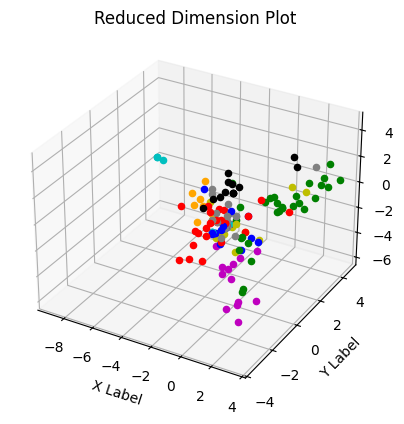

In [ ]:
data = bows
mat_reduced = PCA(data, 3)
principal_df = pd.DataFrame(mat_reduced, columns = ['PC1','PC2','PC3'])
targets = [elm for elm in df.loc[:, 'topic']]
ratings = pd.Categorical(targets)
principal_df['topic'] = ratings.codes

colors = ('b','g','r','c','m','y','k','orange','gray','yellow')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(principal_df["PC1"])):
  ax.scatter(principal_df["PC1"][i], principal_df["PC2"][i], principal_df["PC3"][i], marker='o', color=colors[principal_df["topic"][i]])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title('Reduced Dimension Plot')
plt.show()

### Reduced clustering

#### 3 dimensions

##### Elbow method

<ipython-input-3-30495f8f0749>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))


[0.34774856 0.20295955 0.09438633 0.0596832  0.04819817 0.04195279
 0.03614863 0.03212837 0.02753864]


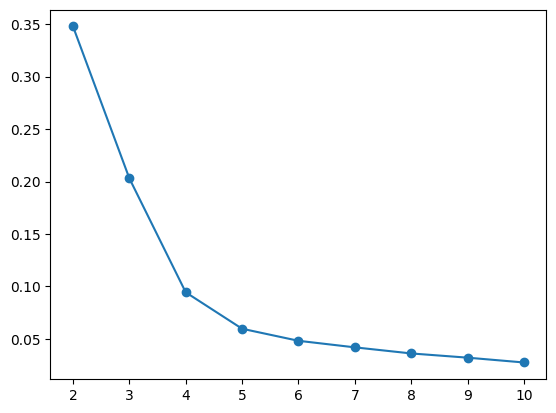

In [ ]:
data = bows
mat_reduced = PCA(data, 3)
data = mat_reduced

ks = list(range(2,11))
dists = [0 for elm in ks]

ind = 0
for K in ks:
  min_dist = 1000000000
  for i in range(20):
    max_iters = 100
    init_cents = kMeansInitCentroids(data, K)
    centroids, idx = runkMeans(data, init_cents, max_iters)
    dist = distanceCalc(data, centroids, idx)
    if dist < min_dist:
      min_dist = dist
  dists[ind] = min_dist
  ind = ind + 1

dists = np.array(dists)
print(dists)

plt.figure
plt.plot(ks, dists, 'o-')
plt.show()

##### Clusters

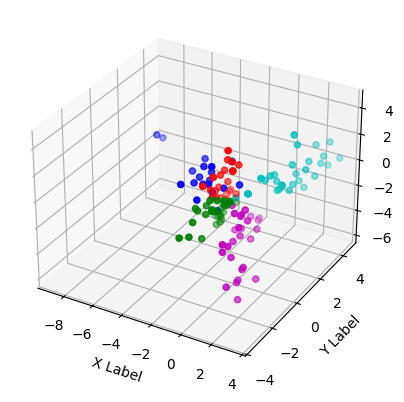

In [ ]:
data = bows
mat_reduced = PCA(data, 3)
K = 5
data = mat_reduced
min_dist = 1000000000
best_centrs, best_idx = None, None
for i in range(10):
    max_iters = 100
    init_cents = kMeansInitCentroids(data, K)
    centroids, idx = runkMeans(data, init_cents, max_iters)
    dist = distanceCalc(data, centroids, idx)
    if dist < min_dist:
      min_dist = dist
      best_centrs, best_idx = centroids, idx

colors = ('b','g','r','c','m','y','k','orange','gray','yellow')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(best_centrs)):
  CL_i = data[np.where(best_idx == i)[0],:]
  #plt.plot(CL_i[:,0],CL_i[:,1], marker='o', color=colors[i])
  ax.scatter(CL_i[:,0], CL_i[:,1], CL_i[:,2], marker='o', color=colors[i])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

##### Evaluation

In [ ]:
# k = 5
purity = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
cluster_count = (max(cluster_df['clusters'].unique())+1)
for i in range(max(cluster_df['clusters'].unique())+1):
  inds = cluster_df[cluster_df['clusters'] == i].index
  cluster_purity = max(df['topic'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Purity:", cluster_purity)
  purity = purity + cluster_purity
purity = purity/cluster_count
print('Purity:', purity)

Cluster: 0 , Purity: 0.35
Cluster: 1 , Purity: 0.359375
Cluster: 2 , Purity: 0.44
Cluster: 3 , Purity: 0.7
Cluster: 4 , Purity: 0.42857142857142855
Purity: 0.4555892857142857


In [ ]:
# k = 5
recall = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
class_count = (max(principal_df['topic'].unique())+1)
for i in range(max(principal_df['topic'].unique())+1):
  inds = principal_df[principal_df['topic'] == i].index
  cluster_recall = max(cluster_df['clusters'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Recall:", cluster_recall)
  recall = recall + cluster_recall
recall = recall/class_count
print('Recall:', recall)

Cluster: 0 , Recall: 0.7142857142857143
Cluster: 1 , Recall: 0.7
Cluster: 2 , Recall: 0.6764705882352942
Cluster: 3 , Recall: 0.5714285714285714
Cluster: 4 , Recall: 0.9230769230769231
Cluster: 5 , Recall: 0.55
Cluster: 6 , Recall: 0.7857142857142857
Cluster: 7 , Recall: 1.0
Cluster: 8 , Recall: 0.42857142857142855
Recall: 0.7055052790346907


In [ ]:
# k = 5
print("                          Cross table")
print()
print("     C/K   ", end=' ')
for j in range(max(principal_df['topic'].unique())+1):
  print(j, end='    ')
print()
print('         -------------------------------------------------')
for i in range(max(cluster_df['clusters'].unique())+1):
  print("     ", end=' ')
  print(i, end='  |  ')
  for j in range(max(principal_df['topic'].unique())+1):
    inds = cluster_df[cluster_df['clusters'] == i].index
    s = [principal_df['topic'] == j][0]
    new_inds = s[s].index.values
    new_inds = [i for i in new_inds if i in inds]
    count = len(principal_df.loc[new_inds])
    if count > 99:
      print(count, end='  ')
    elif count > 9:
      print(count, end='   ')
    else:
      print(count, end='    ')
  print('|', end='  ')
  print(len(inds), end='')
  print()
print('         -------------------------------------------------')
print("           ", end=' ')
for j in range(max(principal_df['topic'].unique())+1):
  count = len(principal_df[principal_df['topic'] == j].index)
  if count > 99:
    print(count, end='  ')
  elif count > 9:
    print(count, end='   ')
  else:
    print(count, end='    ')
print()

                          Cross table

     C/K    0    1    2    3    4    5    6    7    8    
         -------------------------------------------------
      0  |  1    2    3    3    0    2    0    7    2    |  20
      1  |  15   0    23   4    1    11   1    0    9    |  64
      2  |  1    0    4    0    0    1    11   0    8    |  25
      3  |  1    21   3    0    0    2    2    0    1    |  30
      4  |  3    7    1    0    12   4    0    0    1    |  28
         -------------------------------------------------
            21   30   34   7    13   20   14   7    21   


#### 6 dimensions

##### Clusters

In [ ]:
data = bows
mat_reduced = PCA(data, 6)
K = 9
data = mat_reduced
min_dist = 1000000000
best_p = 0
best_centrs, best_idx = None, None
for i in range(10):
    max_iters = 100
    init_cents = kMeansInitCentroids(data, K)
    centroids, idx = runkMeans(data, init_cents, max_iters)
    dist = distanceCalc(data, centroids, idx)
    p = purityCalc(idx)
    #if dist < min_dist:
    #  min_dist = dist
    if best_p < p:
      best_p = p
      best_centrs, best_idx = centroids, idx

##### Evaluation

In [ ]:
# Min number of word occurance is 2
# k = 9
purity = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
cluster_count = (max(cluster_df['clusters'].unique())+1)
for i in range(max(cluster_df['clusters'].unique())+1):
  inds = cluster_df[cluster_df['clusters'] == i].index
  cluster_purity = max(principal_df['topic'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Purity:", cluster_purity)
  purity = purity + cluster_purity
purity = purity/cluster_count
print('Purity:', purity)

Cluster: 0 , Purity: 0.3103448275862069
Cluster: 1 , Purity: 0.8571428571428571
Cluster: 2 , Purity: 0.7857142857142857
Cluster: 3 , Purity: 0.5
Cluster: 4 , Purity: 0.4117647058823529
Cluster: 5 , Purity: 0.7857142857142857
Cluster: 6 , Purity: 0.6
Cluster: 7 , Purity: 0.4444444444444444
Cluster: 8 , Purity: 0.8333333333333334
Purity: 0.614273193313085


In [ ]:
# Min number of word occurance is 2
# k = 9
recall = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
class_count = 9
for i in principal_df['topic'].unique():
  inds = principal_df[principal_df['topic'] == i].index
  cluster_recall = max(cluster_df['clusters'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Recall:", cluster_recall)
  recall = recall + cluster_recall
recall = recall/class_count
print('Recall:', recall)

Cluster: supervised learning , Recall: 0.55
Cluster: classification , Recall: 0.6190476190476191
Cluster: regularization , Recall: 0.8461538461538461
Cluster: feature selection , Recall: 0.6666666666666666
Cluster: neural networks , Recall: 0.5294117647058824
Cluster: text classification , Recall: 0.8571428571428571
Cluster: unsupervised learning , Recall: 0.47619047619047616
Cluster: recommender systems , Recall: 0.5714285714285714
Cluster: time series , Recall: 1.0
Recall: 0.6795602001484354


In [ ]:
# Min number of word occurance is 2
# k = 9
print("                          Cross table")
print()
print("     C/K   ", end=' ')
topics = principal_df['topic'].unique()
topics.sort()
for j in range(len(topics)):
  print(j, end='    ')
print()
print('         -------------------------------------------------')
for i in range(max(cluster_df['clusters'].unique())+1):
  print("     ", end=' ')
  print(i, end='  |  ')
  for j in topics:
    inds = cluster_df[cluster_df['clusters'] == i].index
    s = [principal_df['topic'] == j][0]
    new_inds = s[s].index.values
    new_inds = [i for i in new_inds if i in inds]
    count = len(principal_df.loc[new_inds])
    if count > 99:
      print(count, end='  ')
    elif count > 9:
      print(count, end='   ')
    else:
      print(count, end='    ')
  print('|', end='  ')
  print(len(inds), end='')
  print()
print('         -------------------------------------------------')
print("           ", end=' ')
for j in topics:
  count = len(principal_df[principal_df['topic'] == j].index)
  if count > 99:
    print(count, end='  ')
  elif count > 9:
    print(count, end='   ')
  else:
    print(count, end='    ')
print()

                          Cross table

     C/K    0    1    2    3    4    5    6    7    8    
         -------------------------------------------------
      0  |  13   1    18   4    0    11   1    0    10   |  58
      1  |  0    0    1    0    0    0    12   0    1    |  14
      2  |  0    0    11   0    1    0    1    0    1    |  14
      3  |  3    1    0    0    0    2    0    0    6    |  12
      4  |  1    2    2    3    0    1    0    7    1    |  17
      5  |  0    3    0    0    11   0    0    0    0    |  14
      6  |  0    3    0    0    1    0    0    0    1    |  5
      7  |  4    0    1    0    0    4    0    0    0    |  9
      8  |  0    20   1    0    0    2    0    0    1    |  24
         -------------------------------------------------
            21   30   34   7    13   20   14   7    21   


### Clustering first and then reduction

In [ ]:
num_of_features = 200
corpus = [elm for elm in df.loc[:, 'question']]
corpus = [doc.lower() for doc in corpus]

# corpus with only the keywords
new_corpus = []
for text in list(df['question']):
  words = nltk.word_tokenize(text.lower())
  keywords = ''
  for word in words:
      new_word = WordNetLemmatizer().lemmatize(word)
      if new_word in word2idx and new_word not in keywords:
        keywords = keywords + new_word + ' '
  new_corpus.append(keywords[:-1])

class TransformTokenizer:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, doc):
        return [self.transform(word) for word in nltk.word_tokenize(doc)]

stemmer = nltk.stem.PorterStemmer()
tfidf_vectorizer_stemming = TfidfVectorizer(tokenizer=TransformTokenizer(stemmer.stem), max_df=0.95, min_df=2, max_features=num_of_features)
bows = tfidf_vectorizer_stemming.fit_transform(new_corpus)
bows = [elm.toarray()[0] for elm in bows]
bows = np.array(bows)
bows.shape

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(167, 100)

#### Clustering

<ipython-input-3-30495f8f0749>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-3-30495f8f0749>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-3-30495f8f0749>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-3-30495f8f0749>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-3-30495f8f0749>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-3-30495f8f0749>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-3-30495f8f0749>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-3-30495f8f0749>:8: RuntimeWarning

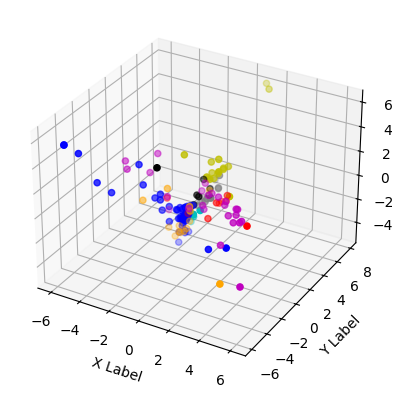

In [ ]:
data = bows
#mat_reduced = PCA(data, 3)
K = 9
#data = mat_reduced
min_dist = 1000000000
best_p = 0
best_centrs, best_idx = None, None
for i in range(20):
    max_iters = 88
    init_cents = kMeansInitCentroids(data, K)
    centroids, idx = runkMeans(data, init_cents, max_iters)
    dist = distanceCalc(data, centroids, idx)
    p = purityCalc(idx)
    #if dist < min_dist:
    #  min_dist = dist
    if best_p < p:
      best_p = p
      best_centrs, best_idx = centroids, idx

data = PCA(data, 3)
colors = ('b','g','r','c','m','y','k','orange','gray','yellow')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(best_centrs)):
  CL_i = data[np.where(best_idx == i)[0],:]
  #plt.plot(CL_i[:,0],CL_i[:,1], marker='o', color=colors[i])
  ax.scatter(CL_i[:,0], CL_i[:,1], CL_i[:,2], marker='o', color=colors[i])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

####Evaluation

In [ ]:
# k = 9
purity = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
cluster_count = (max(cluster_df['clusters'].unique())+1)
for i in range(max(cluster_df['clusters'].unique())+1):
  inds = cluster_df[cluster_df['clusters'] == i].index
  cluster_purity = max(df['topic'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Purity:", cluster_purity)
  purity = purity + cluster_purity
purity = purity/cluster_count
print('Purity:', purity)

Cluster: 0 , Purity: 0.29411764705882354
Cluster: 1 , Purity: 0.6666666666666666
Cluster: 2 , Purity: 1.0
Cluster: 3 , Purity: 1.0
Cluster: 4 , Purity: 0.52
Cluster: 5 , Purity: 0.5625
Cluster: 6 , Purity: 0.7
Cluster: 7 , Purity: 0.8125
Cluster: 8 , Purity: 0.6363636363636364
Purity: 0.6880164388987918


In [ ]:
# k = 9
recall = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
class_count = (len(principal_df['topic'].unique()))
for i in range(class_count):
  inds = principal_df[principal_df['topic'] == principal_df['topic'].unique()[i]].index
  cluster_recall = max(cluster_df['clusters'][inds].value_counts())/len(inds)
  print('Class:', principal_df['topic'].unique()[i], ", Recall:", cluster_recall)
  recall = recall + cluster_recall
recall = recall/class_count
print('Recall:', recall)

Class: supervised learning , Recall: 0.45
Class: classification , Recall: 0.6666666666666666
Class: regularization , Recall: 0.6923076923076923
Class: feature selection , Recall: 0.43333333333333335
Class: neural networks , Recall: 0.5882352941176471
Class: text classification , Recall: 0.5714285714285714
Class: unsupervised learning , Recall: 0.42857142857142855
Class: recommender systems , Recall: 1.0
Class: time series , Recall: 0.7142857142857143
Recall: 0.6160920778567838


In [ ]:
# k = 9
print("                          Cross table")
print()
print("     C/K   ", end=' ')
topics = principal_df['topic'].unique()
i = 0
topics.sort()
for j in topics:
  print(i, end='    ')
  i = i + 1
print()
print('         -------------------------------------------------')
for i in range(max(cluster_df['clusters'].unique())+1):
  print("     ", end=' ')
  print(i, end='  |  ')
  for j in topics:
    inds = cluster_df[cluster_df['clusters'] == i].index
    s = [principal_df['topic'] == j][0]
    new_inds = s[s].index.values
    new_inds = [i for i in new_inds if i in inds]
    count = len(principal_df.loc[new_inds])
    if count > 99:
      print(count, end='  ')
    elif count > 9:
      print(count, end='   ')
    else:
      print(count, end='    ')
  print('|', end='  ')
  print(len(inds), end='')
  print()
print('         -------------------------------------------------')
print("           ", end=' ')
for j in topics:
  count = len(principal_df[principal_df['topic'] == j].index)
  if count > 99:
    print(count, end='  ')
  elif count > 9:
    print(count, end='   ')
  else:
    print(count, end='    ')
print()

                          Cross table

     C/K    0    1    2    3    4    5    6    7    8    
         -------------------------------------------------
      0  |  14   0    20   7    1    9    3    5    9    |  68
      1  |  1    0    0    0    0    0    0    0    2    |  3
      2  |  0    10   0    0    0    0    0    0    0    |  10
      3  |  0    0    0    0    0    0    8    0    0    |  8
      4  |  1    13   1    0    0    5    2    2    1    |  25
      5  |  4    0    0    0    9    3    0    0    0    |  16
      6  |  1    0    0    0    0    2    0    0    7    |  10
      7  |  0    0    13   0    0    1    1    0    1    |  16
      8  |  0    7    0    0    3    0    0    0    1    |  11
         -------------------------------------------------
            21   30   34   7    13   20   14   7    21   


# Topic extended dataset

In [ ]:
data_path = "dataset_extended_topic.csv"
df = pd.read_csv(data_path)
df

,question,topic
0,What is collaborative filtering?,recommender systems
1,What kind of CNN architectures for classificat...,neural networks
2,How can we deal with the imbalanced class dist...,supervised learning
3,What is time series and how it is different fr...,time series
4,What’s a convolutional layer?,neural networks
...,...,...
813,What do you mean by transfer learning?,unsupervised learning
814,What is Adam? What’s the main difference betwe...,neural networks
815,What is the difference between Logistic Regres...,classification
816,What are the common approaches to building an ...,recommender systems


In [ ]:
df['topic'].value_counts()

,count
topic,
unsupervised learning,128
supervised learning,118
regularization,95
feature selection,95
recommender systems,86
classification,83
neural networks,71
time series,71
text classification,71


## 1. Tokenizer

In [ ]:
key_vectors = []
vec_len = 10
#vec_len = 5
for text in list(df['question']):
  vec_rep = []
  words = nltk.word_tokenize(text.lower())
  keywords = []
  for word in words:
      new_word = WordNetLemmatizer().lemmatize(word)
      if new_word in word2idx and new_word not in keywords:
        keywords.append(new_word)
        vec_rep.append(word2idx[new_word])
  #vec_rep.sort()
  if len(vec_rep) >= vec_len:
    vec_rep = vec_rep[:vec_len]
  else:
    vec_rep = vec_rep + [0 for x in range(vec_len - len(vec_rep))]
  vec_rep = np.array(vec_rep)
  key_vectors.append(vec_rep)
key_vectors = np.array(key_vectors)
key_vectors

array([[193, 194,   0, ...,   0,   0,   0],
       [ 48,  66,   7, ...,   0,   0,   0],
       [ 72,  37,  10, ...,   0,   0,   0],
       ...,
       [ 23,  42,   6, ...,   0,   0,   0],
       [ 27, 192,  68, ...,   0,   0,   0],
       [ 42,   6,   0, ...,   0,   0,   0]])

### Reduced

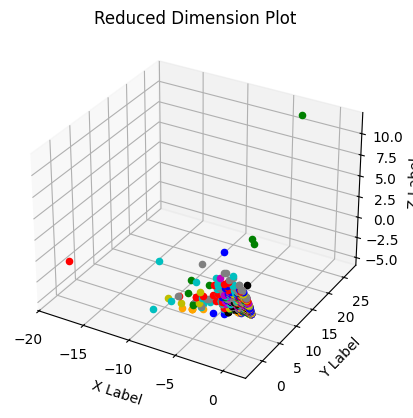

In [ ]:
data = key_vectors
mat_reduced = PCA(data, 3)
principal_df = pd.DataFrame(mat_reduced, columns = ['PC1','PC2','PC3'])
targets = [elm for elm in df.loc[:, 'topic']]
ratings = pd.Categorical(targets)
principal_df['topic'] = ratings.codes

colors = ('b','g','r','c','m','y','k','orange','gray','yellow')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(principal_df["PC1"])):
  ax.scatter(principal_df["PC1"][i], principal_df["PC2"][i], principal_df["PC3"][i], marker='o', color=colors[principal_df["topic"][i]])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title('Reduced Dimension Plot')
plt.show()

## 2. Bag of words

In [ ]:
bag_vectors = []
for text in list(df['question']):
  bag_vec = [0 for x in word2idx]
  words = nltk.word_tokenize(text.lower())
  for word in words:
      new_word = WordNetLemmatizer().lemmatize(word)
      if new_word in word2idx:
        bag_vec[word2idx[new_word]] = bag_vec[word2idx[new_word]] + 1
  bag_vec = np.array(bag_vec)
  bag_vectors.append(bag_vec)
bag_vectors = np.array(bag_vectors)
print(bag_vectors.shape)
bag_vectors

(818, 198)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Visualization

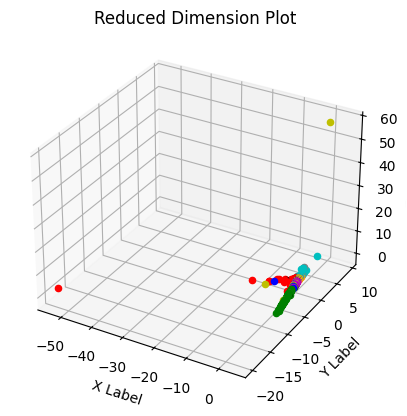

In [ ]:
data = bag_vectors
mat_reduced = PCA(data, 3)
principal_df = pd.DataFrame(mat_reduced, columns = ['PC1','PC2','PC3'])
targets = [elm for elm in df.loc[:, 'topic']]
ratings = pd.Categorical(targets)
principal_df['topic'] = ratings.codes

colors = ('b','g','r','c','m','y','k','orange','gray','yellow')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(principal_df["PC1"])):
  ax.scatter(principal_df["PC1"][i], principal_df["PC2"][i], principal_df["PC3"][i], marker='o', color=colors[principal_df["topic"][i]])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title('Reduced Dimension Plot')
plt.show()

### Clustering first and then reduction

#### Clustering

<ipython-input-2-a358be26bd1d>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-2-a358be26bd1d>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-2-a358be26bd1d>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-2-a358be26bd1d>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-2-a358be26bd1d>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-2-a358be26bd1d>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))


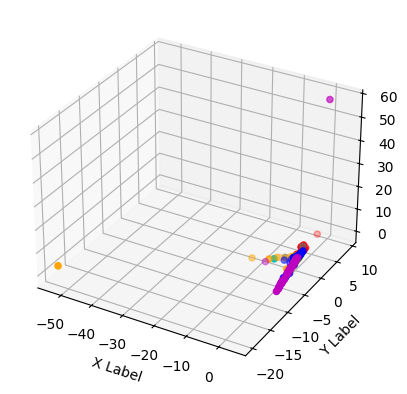

In [ ]:
data = bag_vectors
#mat_reduced = PCA(data, 3)
K = 9
#data = mat_reduced
min_dist = 1000000000
best_p = 0
best_centrs, best_idx = None, None
for i in range(20):
    max_iters = 100
    init_cents = kMeansInitCentroids(data, K)
    centroids, idx = runkMeans(data, init_cents, max_iters)
    dist = distanceCalc(data, centroids, idx)
    p = purityCalc(idx)
    #if dist < min_dist:
    #  min_dist = dist
    if best_p < p:
      best_p = p
      best_centrs, best_idx = centroids, idx

data = PCA(data, 3)
colors = ('b','g','r','c','m','y','k','orange','gray','yellow')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(best_centrs)):
  CL_i = data[np.where(best_idx == i)[0],:]
  #plt.plot(CL_i[:,0],CL_i[:,1], marker='o', color=colors[i])
  ax.scatter(CL_i[:,0], CL_i[:,1], CL_i[:,2], marker='o', color=colors[i])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

#### Evaluation

In [ ]:
# k = 9
purity = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
cluster_count = (max(cluster_df['clusters'].unique())+1)
for i in range(max(cluster_df['clusters'].unique())+1):
  inds = cluster_df[cluster_df['clusters'] == i].index
  cluster_purity = max(principal_df['topic'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Purity:", cluster_purity)
  purity = purity + cluster_purity
purity = purity/cluster_count
print('Purity:', purity)

Cluster: 0 , Purity: 0.215311004784689
Cluster: 1 , Purity: 0.9861111111111112
Cluster: 2 , Purity: 0.9538461538461539
Cluster: 3 , Purity: 0.5833333333333334
Cluster: 4 , Purity: 0.3212121212121212
Cluster: 5 , Purity: 0.921875
Cluster: 6 , Purity: 0.8
Cluster: 7 , Purity: 0.8648648648648649
Cluster: 8 , Purity: 0.8518518518518519
Purity: 0.7220450490004584


In [ ]:
# k = 9
recall = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
class_count = len(principal_df['topic'].unique())
for i in range(len(principal_df['topic'].unique())):
  inds = principal_df[principal_df['topic'] == principal_df['topic'].unique()[i]].index
  cluster_recall = max(cluster_df['clusters'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Recall:", cluster_recall)
  recall = recall + cluster_recall
recall = recall/class_count
print('Recall:', recall)

Cluster: 0 , Recall: 0.7209302325581395
Cluster: 1 , Recall: 0.4507042253521127
Cluster: 2 , Recall: 0.3813559322033898
Cluster: 3 , Recall: 1.0
Cluster: 4 , Recall: 0.546875
Cluster: 5 , Recall: 0.5578947368421052
Cluster: 6 , Recall: 0.6210526315789474
Cluster: 7 , Recall: 0.43373493975903615
Cluster: 8 , Recall: 0.971830985915493
Recall: 0.6315976315788027


In [ ]:
df['topic'].unique()

array(['recommender systems', 'neural networks', 'supervised learning',
       'time series', 'unsupervised learning', 'feature selection',
       'regularization', 'classification', 'text classification'],
      dtype=object)

In [ ]:
# k = 9
print("                          Cross table")
print()
print("     C/K   ", end=' ')
topics = principal_df['topic'].unique()
i = 0
topics.sort()
for j in topics:
  print(i, end='    ')
  i = i + 1
print()
print('         -------------------------------------------------')
for i in range(max(cluster_df['clusters'].unique())+1):
  print("     ", end=' ')
  print(i, end='  |  ')
  for j in topics:
    inds = cluster_df[cluster_df['clusters'] == i].index
    s = [principal_df['topic'] == j][0]
    new_inds = s[s].index.values
    new_inds = [i for i in new_inds if i in inds]
    count = len(principal_df.loc[new_inds])
    if count > 99:
      print(count, end='  ')
    elif count > 9:
      print(count, end='   ')
    else:
      print(count, end='    ')
  print('|', end='  ')
  print(len(inds), end='')
  print()
print('         -------------------------------------------------')
print("           ", end=' ')
for j in topics:
  count = len(principal_df[principal_df['topic'] == j].index)
  if count > 99:
    print(count, end='  ')
  elif count > 9:
    print(count, end='   ')
  else:
    print(count, end='    ')
print()

                          Cross table

     C/K    0    1    2    3    4    5    6    7    8    
         -------------------------------------------------
      0  |  35   38   28   19   1    45   0    0    43   |  209
      1  |  0    0    0    0    0    0    0    71   1    |  72
      2  |  0    0    0    62   0    0    0    0    3    |  65
      3  |  2    1    7    5    1    34   0    0    70   |  120
      4  |  36   53   2    0    34   36   0    0    4    |  165
      5  |  0    3    1    0    59   0    0    0    1    |  64
      6  |  1    0    0    0    0    0    0    0    4    |  5
      7  |  0    0    32   0    0    3    2    0    0    |  37
      8  |  9    0    1    0    0    0    69   0    2    |  81
         -------------------------------------------------
            83   95   71   86   95   118  71   71   128  


### Reduced clustering

#### 3 dimensions

##### Elbow method

<ipython-input-3-30495f8f0749>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))


[0.11975714 0.08350335 0.07327606 0.05861242 0.05266309 0.04513979
 0.04152754 0.03689282 0.02318073]


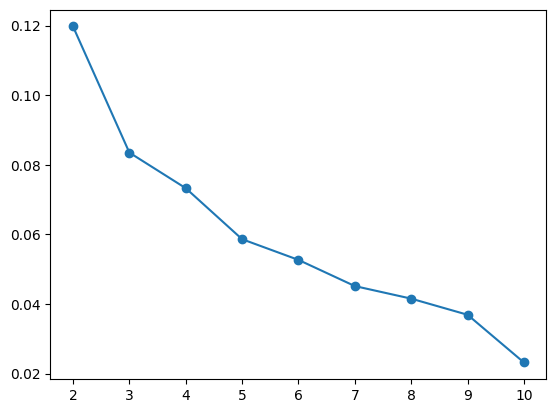

In [ ]:
data = bag_vectors
mat_reduced = PCA(data, 3)
data = mat_reduced

ks = list(range(2,11))
dists = [0 for elm in ks]

ind = 0
for K in ks:
  min_dist = 1000000000
  for i in range(20):
    max_iters = 100
    init_cents = kMeansInitCentroids(data, K)
    centroids, idx = runkMeans(data, init_cents, max_iters)
    dist = distanceCalc(data, centroids, idx)
    if dist < min_dist:
      min_dist = dist
  dists[ind] = min_dist
  ind = ind + 1

dists = np.array(dists)
print(dists)

plt.figure
plt.plot(ks, dists, 'o-')
plt.show()

##### Clusters

<ipython-input-3-30495f8f0749>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))


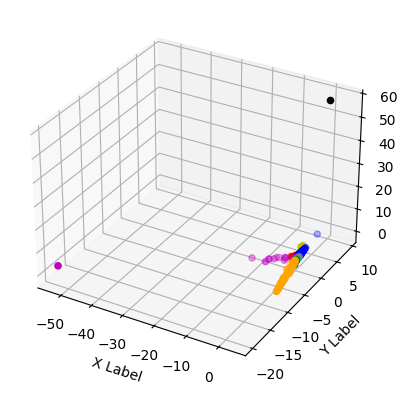

In [ ]:
data = bag_vectors
mat_reduced = PCA(data, 3)
K = 9
data = mat_reduced
min_dist = 1000000000
best_centrs, best_idx = None, None
for i in range(20):
    max_iters = 100
    init_cents = kMeansInitCentroids(data, K)
    centroids, idx = runkMeans(data, init_cents, max_iters)
    dist = distanceCalc(data, centroids, idx)
    if dist < min_dist:
      min_dist = dist
      best_centrs, best_idx = centroids, idx

colors = ('b','g','r','c','m','y','k','orange','gray','yellow')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(best_centrs)):
  CL_i = data[np.where(best_idx == i)[0],:]
  #plt.plot(CL_i[:,0],CL_i[:,1], marker='o', color=colors[i])
  ax.scatter(CL_i[:,0], CL_i[:,1], CL_i[:,2], marker='o', color=colors[i])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

##### Evaluation

In [ ]:
# k = 9
purity = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
cluster_count = (max(cluster_df['clusters'].unique())+1)
for i in range(max(cluster_df['clusters'].unique())+1):
  inds = cluster_df[cluster_df['clusters'] == i].index
  cluster_purity = max(df['topic'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Purity:", cluster_purity)
  purity = purity + cluster_purity
purity = purity/cluster_count
print('Purity:', purity)

Cluster: 0 , Purity: 0.2562358276643991
Cluster: 1 , Purity: 0.5777777777777777
Cluster: 2 , Purity: 0.8461538461538461
Cluster: 3 , Purity: 0.35
Cluster: 4 , Purity: 0.7692307692307693
Cluster: 5 , Purity: 0.8571428571428571
Cluster: 6 , Purity: 1.0
Cluster: 7 , Purity: 0.5757575757575758
Cluster: 8 , Purity: 0.36363636363636365
Purity: 0.6217705574848432


In [ ]:
# k = 9
recall = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
class_count = (max(principal_df['topic'].unique())+1)
for i in range(max(principal_df['topic'].unique())+1):
  inds = principal_df[principal_df['topic'] == i].index
  cluster_recall = max(cluster_df['clusters'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Recall:", cluster_recall)
  recall = recall + cluster_recall
recall = recall/class_count
print('Recall:', recall)

Cluster: 0 , Recall: 0.5180722891566265
Cluster: 1 , Recall: 0.8
Cluster: 2 , Recall: 0.4647887323943662
Cluster: 3 , Recall: 0.9186046511627907
Cluster: 4 , Recall: 0.5473684210526316
Cluster: 5 , Recall: 0.5508474576271186
Cluster: 6 , Recall: 0.8309859154929577
Cluster: 7 , Recall: 0.7323943661971831
Cluster: 8 , Recall: 0.8828125
Recall: 0.6939860370092972


In [ ]:
# k = 9
print("                          Cross table")
print()
print("     C/K   ", end=' ')
for j in range(max(principal_df['topic'].unique())+1):
  print(j, end='    ')
print()
print('         -------------------------------------------------')
for i in range(max(cluster_df['clusters'].unique())+1):
  print("     ", end=' ')
  print(i, end='  |  ')
  for j in range(max(principal_df['topic'].unique())+1):
    inds = cluster_df[cluster_df['clusters'] == i].index
    s = [principal_df['topic'] == j][0]
    new_inds = s[s].index.values
    new_inds = [i for i in new_inds if i in inds]
    count = len(principal_df.loc[new_inds])
    if count > 99:
      print(count, end='  ')
    elif count > 9:
      print(count, end='   ')
    else:
      print(count, end='    ')
  print('|', end='  ')
  print(len(inds), end='')
  print()
print('         -------------------------------------------------')
print("           ", end=' ')
for j in range(max(principal_df['topic'].unique())+1):
  count = len(principal_df[principal_df['topic'] == j].index)
  if count > 99:
    print(count, end='  ')
  elif count > 9:
    print(count, end='   ')
  else:
    print(count, end='    ')
print()

                          Cross table

     C/K    0    1    2    3    4    5    6    7    8    
         -------------------------------------------------
      0  |  43   0    22   79   8    65   59   52   113  |  441
      1  |  9    8    0    0    52   13   0    2    6    |  90
      2  |  0    0    33   1    0    0    5    0    0    |  39
      3  |  3    9    1    0    14   6    0    4    3    |  40
      4  |  1    0    10   0    0    1    1    0    0    |  13
      5  |  0    0    0    6    0    0    0    0    1    |  7
      6  |  0    0    0    0    0    1    0    0    0    |  1
      7  |  16   76   5    0    15   12   3    0    5    |  132
      8  |  11   2    0    0    6    20   3    13   0    |  55
         -------------------------------------------------
            83   95   71   86   95   118  71   71   128  


## 3. TF-IDF

In [ ]:
num_of_features = 200
corpus = [elm for elm in df.loc[:, 'question']]
corpus = [doc.lower() for doc in corpus]

# corpus with only the keywords
new_corpus = []
for text in list(df['question']):
  words = nltk.word_tokenize(text.lower())
  keywords = ''
  for word in words:
      new_word = WordNetLemmatizer().lemmatize(word)
      if new_word in word2idx and new_word not in keywords:
        keywords = keywords + new_word + ' '
  new_corpus.append(keywords[:-1])

class TransformTokenizer:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, doc):
        return [self.transform(word) for word in nltk.word_tokenize(doc)]

stemmer = nltk.stem.PorterStemmer()
tfidf_vectorizer_stemming = TfidfVectorizer(tokenizer=TransformTokenizer(stemmer.stem), max_df=0.99, min_df=8, max_features=num_of_features)
#tfidf_vectorizer_stemming = TfidfVectorizer(tokenizer=TransformTokenizer(stemmer.stem), max_df=0.95, min_df=8, max_features=num_of_features)
bows = tfidf_vectorizer_stemming.fit_transform(new_corpus)
bows = [elm.toarray()[0] for elm in bows]
bows = np.array(bows)
bows

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.5502149, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [ ]:
bows.shape

(818, 66)

### Visualization

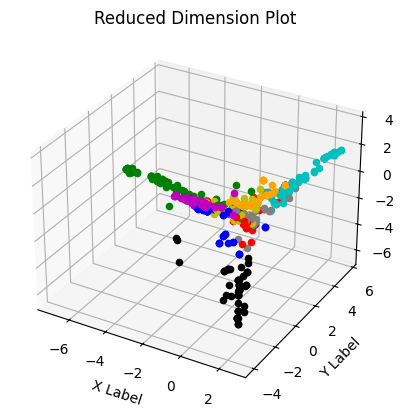

In [ ]:
data = bows
mat_reduced = PCA(data, 3)
principal_df = pd.DataFrame(mat_reduced, columns = ['PC1','PC2','PC3'])
targets = [elm for elm in df.loc[:, 'topic']]
ratings = pd.Categorical(targets)
principal_df['topic'] = ratings.codes

# classification, feature selection, neural networks, recommender systems, regularization, supervised learning, text classification, time series and unsupervised learning
colors = ('b','g','r','c','m','y','k','orange','gray','yellow')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(principal_df["PC1"])):
  ax.scatter(principal_df["PC1"][i], principal_df["PC2"][i], principal_df["PC3"][i], marker='o', color=colors[principal_df["topic"][i]])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title('Reduced Dimension Plot')
plt.show()

### Reduced clustering

#### 3 dimensions

##### Elbow method

<ipython-input-3-30495f8f0749>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))


[0.35060538 0.15953837 0.11333045 0.04773374 0.04053387 0.03474332
 0.03182008 0.02876501 0.0261682 ]


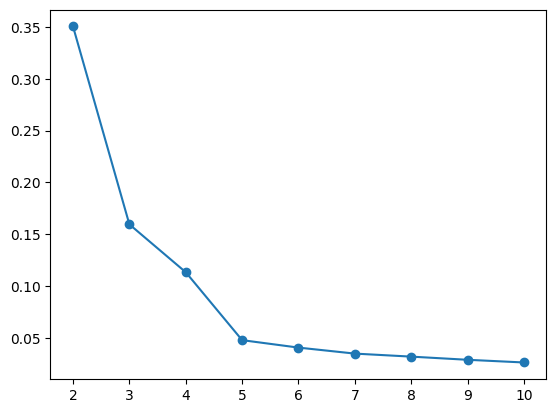

In [ ]:
data = bows
mat_reduced = PCA(data, 3)
data = mat_reduced

ks = list(range(2,11))
dists = [0 for elm in ks]

ind = 0
for K in ks:
  min_dist = 1000000000
  for i in range(20):
    max_iters = 100
    init_cents = kMeansInitCentroids(data, K)
    centroids, idx = runkMeans(data, init_cents, max_iters)
    dist = distanceCalc(data, centroids, idx)
    if dist < min_dist:
      min_dist = dist
  dists[ind] = min_dist
  ind = ind + 1

dists = np.array(dists)
print(dists)

plt.figure
plt.plot(ks, dists, 'o-')
plt.show()

##### Clusters

<ipython-input-3-30495f8f0749>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))


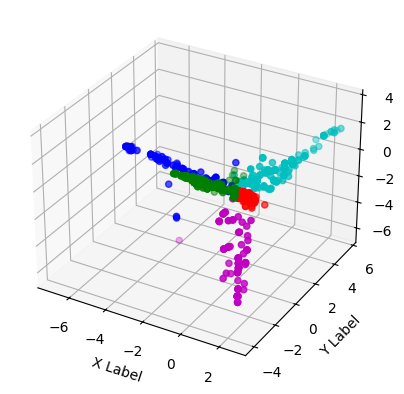

In [ ]:
data = bows
mat_reduced = PCA(data, 3)
K = 5
data = mat_reduced
min_dist = 1000000000
best_centrs, best_idx = None, None
for i in range(20):
    max_iters = 100
    init_cents = kMeansInitCentroids(data, K)
    centroids, idx = runkMeans(data, init_cents, max_iters)
    dist = distanceCalc(data, centroids, idx)
    if dist < min_dist:
      min_dist = dist
      best_centrs, best_idx = centroids, idx

colors = ('b','g','r','c','m','y','k','orange','gray','yellow')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(best_centrs)):
  CL_i = data[np.where(best_idx == i)[0],:]
  #plt.plot(CL_i[:,0],CL_i[:,1], marker='o', color=colors[i])
  ax.scatter(CL_i[:,0], CL_i[:,1], CL_i[:,2], marker='o', color=colors[i])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

<ipython-input-3-30495f8f0749>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))


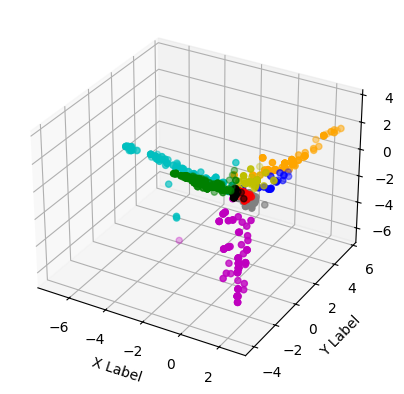

In [ ]:
data = bows
mat_reduced = PCA(data, 3)
K = 9
data = mat_reduced
min_dist = 1000000000
best_centrs, best_idx = None, None
for i in range(20):
    max_iters = 100
    init_cents = kMeansInitCentroids(data, K)
    centroids, idx = runkMeans(data, init_cents, max_iters)
    dist = distanceCalc(data, centroids, idx)
    if dist < min_dist:
      min_dist = dist
      best_centrs, best_idx = centroids, idx

colors = ('b','g','r','c','m','y','k','orange','gray','yellow')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(best_centrs)):
  CL_i = data[np.where(best_idx == i)[0],:]
  #plt.plot(CL_i[:,0],CL_i[:,1], marker='o', color=colors[i])
  ax.scatter(CL_i[:,0], CL_i[:,1], CL_i[:,2], marker='o', color=colors[i])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

##### Evaluation

In [ ]:
# k = 5
purity = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
cluster_count = (max(cluster_df['clusters'].unique())+1)
for i in range(max(cluster_df['clusters'].unique())+1):
  inds = cluster_df[cluster_df['clusters'] == i].index
  cluster_purity = max(df['topic'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Purity:", cluster_purity)
  purity = purity + cluster_purity
purity = purity/cluster_count
print('Purity:', purity)

Cluster: 0 , Purity: 0.797979797979798
Cluster: 1 , Purity: 0.45893719806763283
Cluster: 2 , Purity: 0.39662447257383965
Cluster: 3 , Purity: 0.4473684210526316
Cluster: 4 , Purity: 0.8117647058823529
Purity: 0.582534919111251


In [ ]:
# k = 5
recall = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
class_count = (max(principal_df['topic'].unique())+1)
for i in range(max(principal_df['topic'].unique())+1):
  inds = principal_df[principal_df['topic'] == i].index
  cluster_recall = max(cluster_df['clusters'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Recall:", cluster_recall)
  recall = recall + cluster_recall
recall = recall/class_count
print('Recall:', recall)

Cluster: 0 , Recall: 0.39759036144578314
Cluster: 1 , Recall: 0.8315789473684211
Cluster: 2 , Recall: 0.8028169014084507
Cluster: 3 , Recall: 0.9883720930232558
Cluster: 4 , Recall: 1.0
Cluster: 5 , Recall: 0.4406779661016949
Cluster: 6 , Recall: 0.971830985915493
Cluster: 7 , Recall: 0.9436619718309859
Cluster: 8 , Recall: 0.734375
Recall: 0.7901004696771206


In [ ]:
# k = 5
print("                          Cross table")
print()
print("     C/K   ", end=' ')
for j in range(max(principal_df['topic'].unique())+1):
  print(j, end='    ')
print()
print('         -------------------------------------------------')
for i in range(max(cluster_df['clusters'].unique())+1):
  print("     ", end=' ')
  print(i, end='  |  ')
  for j in range(max(principal_df['topic'].unique())+1):
    inds = cluster_df[cluster_df['clusters'] == i].index
    s = [principal_df['topic'] == j][0]
    new_inds = s[s].index.values
    new_inds = [i for i in new_inds if i in inds]
    count = len(principal_df.loc[new_inds])
    if count > 99:
      print(count, end='  ')
    elif count > 9:
      print(count, end='   ')
    else:
      print(count, end='    ')
  print('|', end='  ')
  print(len(inds), end='')
  print()
print('         -------------------------------------------------')
print("           ", end=' ')
for j in range(max(principal_df['topic'].unique())+1):
  count = len(principal_df[principal_df['topic'] == j].index)
  if count > 99:
    print(count, end='  ')
  elif count > 9:
    print(count, end='   ')
  else:
    print(count, end='    ')
print()

                          Cross table

     C/K    0    1    2    3    4    5    6    7    8    
         -------------------------------------------------
      0  |  0    79   4    0    0    6    2    0    8    |  99
      1  |  32   13   3    0    95   52   0    4    8    |  207
      2  |  33   2    57   1    0    50   0    0    94   |  237
      3  |  7    1    4    85   0    10   0    67   16   |  190
      4  |  11   0    3    0    0    0    69   0    2    |  85
         -------------------------------------------------
            83   95   71   86   95   118  71   71   128  


In [ ]:
# k = 9
purity = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
cluster_count = (max(cluster_df['clusters'].unique())+1)
for i in range(max(cluster_df['clusters'].unique())+1):
  inds = cluster_df[cluster_df['clusters'] == i].index
  cluster_purity = max(df['topic'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Purity:", cluster_purity)
  purity = purity + cluster_purity
purity = purity/cluster_count
print('Purity:', purity)

Cluster: 0 , Purity: 0.45
Cluster: 1 , Purity: 0.5081967213114754
Cluster: 2 , Purity: 0.2830188679245283
Cluster: 3 , Purity: 0.797979797979798
Cluster: 4 , Purity: 0.8117647058823529
Cluster: 5 , Purity: 0.75
Cluster: 6 , Purity: 0.6666666666666666
Cluster: 7 , Purity: 0.7281553398058253
Cluster: 8 , Purity: 0.5241935483870968
Purity: 0.6133306275508604


In [ ]:
# k = 9
recall = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
class_count = (max(principal_df['topic'].unique())+1)
for i in range(max(principal_df['topic'].unique())+1):
  inds = principal_df[principal_df['topic'] == i].index
  cluster_recall = max(cluster_df['clusters'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Recall:", cluster_recall)
  recall = recall + cluster_recall
recall = recall/class_count
print('Recall:', recall)

Cluster: 0 , Recall: 0.3855421686746988
Cluster: 1 , Recall: 0.8315789473684211
Cluster: 2 , Recall: 0.5633802816901409
Cluster: 3 , Recall: 0.872093023255814
Cluster: 4 , Recall: 0.9789473684210527
Cluster: 5 , Recall: 0.2966101694915254
Cluster: 6 , Recall: 0.971830985915493
Cluster: 7 , Recall: 0.7183098591549296
Cluster: 8 , Recall: 0.5078125
Recall: 0.6806783671080083


In [ ]:
# k = 9
print("                          Cross table")
print()
print("     C/K   ", end=' ')
for j in range(max(principal_df['topic'].unique())+1):
  print(j, end='    ')
print()
print('         -------------------------------------------------')
for i in range(max(cluster_df['clusters'].unique())+1):
  print("     ", end=' ')
  print(i, end='  |  ')
  for j in range(max(principal_df['topic'].unique())+1):
    inds = cluster_df[cluster_df['clusters'] == i].index
    s = [principal_df['topic'] == j][0]
    new_inds = s[s].index.values
    new_inds = [i for i in new_inds if i in inds]
    count = len(principal_df.loc[new_inds])
    if count > 99:
      print(count, end='  ')
    elif count > 9:
      print(count, end='   ')
    else:
      print(count, end='    ')
  print('|', end='  ')
  print(len(inds), end='')
  print()
print('         -------------------------------------------------')
print("           ", end=' ')
for j in range(max(principal_df['topic'].unique())+1):
  count = len(principal_df[principal_df['topic'] == j].index)
  if count > 99:
    print(count, end='  ')
  elif count > 9:
    print(count, end='   ')
  else:
    print(count, end='    ')
print()

                          Cross table

     C/K    0    1    2    3    4    5    6    7    8    
         -------------------------------------------------
      0  |  1    0    2    9    0    1    0    0    7    |  20
      1  |  32   12   1    0    93   35   0    4    6    |  183
      2  |  28   2    16   1    0    30   0    0    29   |  106
      3  |  0    79   4    0    0    6    2    0    8    |  99
      4  |  11   0    3    0    0    0    69   0    2    |  85
      5  |  1    1    0    1    0    10   0    51   4    |  68
      6  |  2    1    3    0    2    20   0    0    2    |  30
      7  |  5    0    2    75   0    0    0    16   5    |  103
      8  |  3    0    40   0    0    16   0    0    65   |  124
         -------------------------------------------------
            83   95   71   86   95   118  71   71   128  


#### 6 dimension

##### Clusters

In [ ]:
data = bows
mat_reduced = PCA(data, 6)
K = 9
data = mat_reduced
min_dist = 1000000000
best_p = 0
best_centrs, best_idx = None, None
for i in range(20):
    max_iters = 100
    init_cents = kMeansInitCentroids(data, K)
    centroids, idx = runkMeans(data, init_cents, max_iters)
    dist = distanceCalc(data, centroids, idx)
    p = purityCalc(idx)
    #if dist < min_dist:
    #  min_dist = dist
    if best_p < p:
      best_p = p
      best_centrs, best_idx = centroids, idx

##### Evaluation

In [ ]:
# k = 9
purity = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
cluster_count = (max(cluster_df['clusters'].unique())+1)
for i in range(max(cluster_df['clusters'].unique())+1):
  inds = cluster_df[cluster_df['clusters'] == i].index
  cluster_purity = max(principal_df['topic'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Purity:", cluster_purity)
  purity = purity + cluster_purity
purity = purity/cluster_count
print('Purity:', purity)

Cluster: 0 , Purity: 0.8571428571428571
Cluster: 1 , Purity: 0.8172043010752689
Cluster: 2 , Purity: 1.0
Cluster: 3 , Purity: 0.5508982035928144
Cluster: 4 , Purity: 0.9397590361445783
Cluster: 5 , Purity: 0.9054054054054054
Cluster: 6 , Purity: 0.8160919540229885
Cluster: 7 , Purity: 0.36363636363636365
Cluster: 8 , Purity: 0.5704697986577181
Purity: 0.7578453244086659


In [ ]:
# k = 9
recall = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
class_count = 9
for i in principal_df['topic'].unique():
  inds = principal_df[principal_df['topic'] == i].index
  cluster_recall = max(cluster_df['clusters'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Recall:", cluster_recall)
  recall = recall + cluster_recall
recall = recall/class_count
print('Recall:', recall)

Cluster: recommender systems , Recall: 0.9069767441860465
Cluster: neural networks , Recall: 0.676056338028169
Cluster: supervised learning , Recall: 0.3728813559322034
Cluster: time series , Recall: 1.0
Cluster: unsupervised learning , Recall: 0.6640625
Cluster: feature selection , Recall: 0.8
Cluster: regularization , Recall: 0.968421052631579
Cluster: classification , Recall: 0.37349397590361444
Cluster: text classification , Recall: 0.9436619718309859
Recall: 0.7450615487236221


In [ ]:
# k = 9
print("                          Cross table")
print()
print("     C/K   ", end=' ')
topics = principal_df['topic'].unique()
topics.sort()
for j in range(len(topics)):
  print(j, end='    ')
print()
print('         -------------------------------------------------')
for i in range(max(cluster_df['clusters'].unique())+1):
  print("     ", end=' ')
  print(i, end='  |  ')
  for j in topics:
    inds = cluster_df[cluster_df['clusters'] == i].index
    s = [principal_df['topic'] == j][0]
    new_inds = s[s].index.values
    new_inds = [i for i in new_inds if i in inds]
    count = len(principal_df.loc[new_inds])
    if count > 99:
      print(count, end='  ')
    elif count > 9:
      print(count, end='   ')
    else:
      print(count, end='    ')
  print('|', end='  ')
  print(len(inds), end='')
  print()
print('         -------------------------------------------------')
print("           ", end=' ')
for j in topics:
  count = len(principal_df[principal_df['topic'] == j].index)
  if count > 99:
    print(count, end='  ')
  elif count > 9:
    print(count, end='   ')
  else:
    print(count, end='    ')
print()

                          Cross table

     C/K    0    1    2    3    4    5    6    7    8    
         -------------------------------------------------
      0  |  0    1    48   1    1    2    2    0    1    |  56
      1  |  0    76   1    0    0    6    2    0    8    |  93
      2  |  10   0    0    0    0    0    0    0    0    |  10
      3  |  31   12   2    0    92   26   0    0    4    |  167
      4  |  0    1    0    78   0    0    0    0    4    |  83
      5  |  4    0    0    0    0    0    67   0    3    |  74
      6  |  7    0    1    0    0    4    0    71   4    |  87
      7  |  28   1    14   1    0    36   0    0    19   |  99
      8  |  3    4    5    6    2    44   0    0    85   |  149
         -------------------------------------------------
            83   95   71   86   95   118  71   71   128  


## Clustering first and then reduction

In [ ]:
num_of_features = 200
corpus = [elm for elm in df.loc[:, 'question']]
corpus = [doc.lower() for doc in corpus]

# corpus with only the keywords
new_corpus = []
for text in list(df['question']):
  words = nltk.word_tokenize(text.lower())
  keywords = ''
  for word in words:
      new_word = WordNetLemmatizer().lemmatize(word)
      if new_word in word2idx and new_word not in keywords:
        keywords = keywords + new_word + ' '
  new_corpus.append(keywords[:-1])

class TransformTokenizer:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, doc):
        return [self.transform(word) for word in nltk.word_tokenize(doc)]

stemmer = nltk.stem.PorterStemmer()
tfidf_vectorizer_stemming = TfidfVectorizer(tokenizer=TransformTokenizer(stemmer.stem), max_df=0.95, min_df=10, max_features=num_of_features)
bows = tfidf_vectorizer_stemming.fit_transform(new_corpus)
bows = [elm.toarray()[0] for elm in bows]
bows = np.array(bows)
bows.shape

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(818, 61)

#### Clustering

<ipython-input-59-a358be26bd1d>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-59-a358be26bd1d>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-59-a358be26bd1d>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-59-a358be26bd1d>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-59-a358be26bd1d>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-59-a358be26bd1d>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-59-a358be26bd1d>:8: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ((a @ b) / (norm(a)*norm(b)))
<ipython-input-59-a358be26bd1d>:8: Runtim

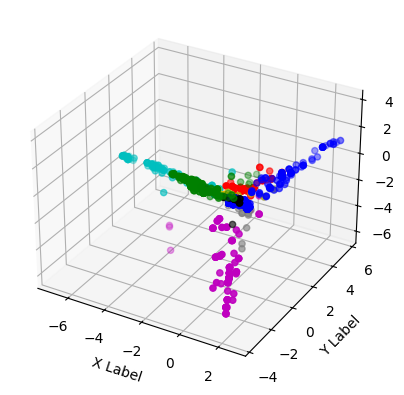

In [ ]:
data = bows
#mat_reduced = PCA(data, 3)
K = 9
#data = mat_reduced
min_dist = 1000000000
best_p = 0
best_centrs, best_idx = None, None
for i in range(20):
    max_iters = 100
    init_cents = kMeansInitCentroids(data, K)
    centroids, idx = runkMeans(data, init_cents, max_iters)
    dist = distanceCalc(data, centroids, idx)
    p = purityCalc(idx)
    #if dist < min_dist:
    #  min_dist = dist
    if best_p < p:
      best_p = p
      best_centrs, best_idx = centroids, idx

data = PCA(data, 3)
colors = ('b','g','r','c','m','y','k','orange','gray','yellow')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(best_centrs)):
  CL_i = data[np.where(best_idx == i)[0],:]
  #plt.plot(CL_i[:,0],CL_i[:,1], marker='o', color=colors[i])
  ax.scatter(CL_i[:,0], CL_i[:,1], CL_i[:,2], marker='o', color=colors[i])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

#### Evaluation

In [ ]:
# k = 9
purity = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
cluster_count = (max(cluster_df['clusters'].unique())+1)
for i in range(max(cluster_df['clusters'].unique())+1):
  inds = cluster_df[cluster_df['clusters'] == i].index
  cluster_purity = max(df['topic'][inds].value_counts())/len(inds)
  print('Cluster:', i, ", Purity:", cluster_purity)
  purity = purity + cluster_purity
purity = purity/cluster_count
print('Purity:', purity)

Cluster: 0 , Purity: 0.315018315018315
Cluster: 1 , Purity: 0.5575757575757576
Cluster: 2 , Purity: 0.9342105263157895
Cluster: 3 , Purity: 0.87
Cluster: 4 , Purity: 0.7931034482758621
Cluster: 5 , Purity: 0.5142857142857142
Cluster: 6 , Purity: 1.0
Cluster: 7 , Purity: 1.0
Cluster: 8 , Purity: 0.9387755102040817
Purity: 0.7692188079639466


In [ ]:
# k = 9
recall = 0
cluster_df = pd.DataFrame()
cluster_df['clusters'] = [int(elm[0]) for elm in best_idx]
class_count = (len(principal_df['topic'].unique()))
for i in range(class_count):
  inds = principal_df[principal_df['topic'] == principal_df['topic'].unique()[i]].index
  cluster_recall = max(cluster_df['clusters'][inds].value_counts())/len(inds)
  print('Class:', principal_df['topic'].unique()[i], ", Recall:", cluster_recall)
  recall = recall + cluster_recall
recall = recall/class_count
print('Recall:', recall)

Class: recommender systems , Recall: 0.9767441860465116
Class: neural networks , Recall: 0.647887323943662
Class: supervised learning , Recall: 0.4830508474576271
Class: time series , Recall: 1.0
Class: unsupervised learning , Recall: 0.671875
Class: feature selection , Recall: 0.9157894736842105
Class: regularization , Recall: 0.968421052631579
Class: classification , Recall: 0.37349397590361444
Class: text classification , Recall: 0.971830985915493
Recall: 0.7787880939536331


In [ ]:
# k = 9
print("                          Cross table")
print()
print("     C/K   ", end=' ')
topics = principal_df['topic'].unique()
i = 0
topics.sort()
for j in topics:
  print(i, end='    ')
  i = i + 1
print()
print('         -------------------------------------------------')
for i in range(max(cluster_df['clusters'].unique())+1):
  print("     ", end=' ')
  print(i, end='  |  ')
  for j in topics:
    inds = cluster_df[cluster_df['clusters'] == i].index
    s = [principal_df['topic'] == j][0]
    new_inds = s[s].index.values
    new_inds = [i for i in new_inds if i in inds]
    count = len(principal_df.loc[new_inds])
    if count > 99:
      print(count, end='  ')
    elif count > 9:
      print(count, end='   ')
    else:
      print(count, end='    ')
  print('|', end='  ')
  print(len(inds), end='')
  print()
print('         -------------------------------------------------')
print("           ", end=' ')
for j in topics:
  count = len(principal_df[principal_df['topic'] == j].index)
  if count > 99:
    print(count, end='  ')
  elif count > 9:
    print(count, end='   ')
  else:
    print(count, end='    ')
print()

                          Cross table

     C/K    0    1    2    3    4    5    6    7    8    
         -------------------------------------------------
      0  |  23   2    20   84   1    57   0    0    86   |  273
      1  |  31   4    3    0    92   34   0    0    1    |  165
      2  |  1    0    0    0    1    2    0    71   1    |  76
      3  |  0    87   1    0    0    6    0    0    6    |  100
      4  |  15   0    1    0    0    0    69   0    2    |  87
      5  |  3    2    0    2    1    18   0    0    9    |  35
      6  |  0    0    0    0    0    0    0    0    23   |  23
      7  |  10   0    0    0    0    0    0    0    0    |  10
      8  |  0    0    46   0    0    1    2    0    0    |  49
         -------------------------------------------------
            83   95   71   86   95   118  71   71   128  



# Merging of topic groups

The topic groups (*neural networks*, *supervised learning*, *unsupervised learning*) merged into one group called *machine learning* (red cluster).

The topic groups (*classification*, *text classification*) merged into one group called *classification* (black cluster).

Green cluster is *feature selection*, cyan is *recommender systems*, orange is *regularization* and magenta is *time series*.


In [20]:
topic_df = pd.DataFrame()
topic_df['topic'] = ratings.codes
topic_df[topic_df['topic'] == 0] = 6
topic_df[topic_df['topic'] == 5] = 2
topic_df[topic_df['topic'] == 8] = 2
len(topic_df['topic'].value_counts())

6

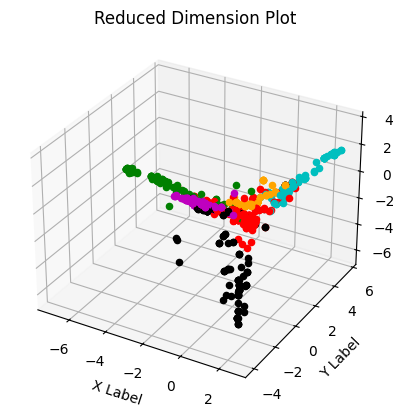

In [ ]:
data = bows
mat_reduced = PCA(data, 3)
principal_df = pd.DataFrame(mat_reduced, columns = ['PC1','PC2','PC3'])
targets = [elm for elm in df.loc[:, 'topic']]
ratings = pd.Categorical(targets)
principal_df['topic'] = ratings.codes
principal_df['topic'] = topic_df['topic']

colors = ('b','g','r','c','m','y','k','orange','gray','yellow')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(len(principal_df["PC1"])):
  ax.scatter(principal_df["PC1"][i], principal_df["PC2"][i], principal_df["PC3"][i], marker='o', color=colors[principal_df["topic"][i]])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title('Reduced Dimension Plot')
plt.show()